In [2]:
# import required packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io

In [3]:
# read Power Amplifier input data
In_file = 'Input_NN_Inverse.mat'
In_x = scipy.io.loadmat(In_file)

# X_Input has "n_examples" rows, and each row is a vector of "memory_complex_PAs+current_input" length
x_input = np.asarray(In_x['X_Input'])
n_examples = len(x_input)

# it is assumed the PA has memory_complex_PAs memory, 
    #thus the output of PA at time t is a function of inputs from time [t:t-memory_complex_PAs]
    #memory_complex_PAs = 2 * memory_real_PAs, it means we need previous " memory_complex_PAs/2" complex inputs of PA

# normalize input for a better training of NN
mean_np=np.mean(x_input,axis=None)
max_np=np.max(np.abs(x_input),axis=None)
x_input=(x_input-mean_np)/(max_np)
X_Train = x_input

In [4]:
# read Outputs of PA at time t
Out_file = 'Output_NN_Inverse.mat'
Out_y = scipy.io.loadmat(Out_file)

# Y_Output has n_examples rows, and each row is the current output of the PA, which has real and imaginary parts
y_output = np.asarray(Out_y['Y_Output'])

mean_np_y=np.mean(y_output,axis=None)
std_np_y=np.max(np.abs(y_output),axis=None)
y_output=(y_output-mean_np_y)/(std_np_y)

Y_Train = y_output
memory_complex_PAs_plus_current_input = y_output[0].shape

In [5]:
# the FC NN has the following layers
# input  layer
input_shape  = memory_complex_PAs_plus_current_input
# hidden layers
layer1_nodes = 64
layer2_nodes = 16
layer3_nodes = 8
# output layer
N_out_layer  = 2

In [6]:
# Defining a model for traning
def create_model():
# input layer/one hidden layer/output layer/
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(layer1_nodes, activation='linear'),                                                    
    keras.layers.Dense(layer1_nodes, activation='tanh'),                                                                                                       
    keras.layers.Dense(layer2_nodes, activation='tanh'),                                                                                                       
    keras.layers.Dense(layer3_nodes, activation='tanh'), 
    keras.layers.Dense(N_out_layer,  activation='tanh'),
    ])    

    # setup the optimizer
    adm = tf.keras.optimizers.Adam(lr=0.001)
    # compile the model
    model.compile(optimizer=adm,loss = 'mse',)
    return model

In [7]:
# Create a basic model instance
model = create_model()

# summary of the model
model.summary()

# Model training
epo=20
b_size=25
model.fit(Y_Train,X_Train, validation_split = 0.05, epochs=epo, batch_size=b_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 6,186
Trainable params: 6,186
Non-trainable params: 0
______________________________________________________

In [8]:
# read test input data
In_file = 'Input_NN_Test_Inverse.mat'
In_x = scipy.io.loadmat(In_file)

# X_Input has n_examples rows, and each row is a vector of "memory_complex_PAs+current_input" length
x_input_Test = np.asarray(In_x['X_Input'])
n_examples_Test = len(x_input_Test)

# normalize input
x_input_Test=(x_input_Test-mean_np)/(max_np)

X_Test = x_input_Test

In [9]:
# read test Outputs of PA
Out_file = 'Output_NN_Test_Inverse.mat'
Out_y = scipy.io.loadmat(Out_file)

# Y_Output has n_examples rows, and each row is the current output of the PA
y_output_Test = np.asarray(Out_y['Y_Output'])

# normalize measured output data
y_output_Test=(y_output_Test-mean_np_y)/(std_np_y)

Y_Test = y_output_Test

# find the estimated output from the model
X_hat = model.predict(Y_Test)

In [12]:
# find the MSE of NN and the measured data
MSE_Model = np.square(np.abs(X_hat-X_Test)).mean(axis = None)
print('MSE is: ',MSE_Model)

MSE is:  4.946422374644198e-05


In [13]:
# find the absolute value of the NN output
X_real_hat = X_hat[:,0]
X_imag_hat = X_hat[:,1]
X_abs_hat = np.sqrt(np.square(X_imag_hat) + np.square(X_real_hat))

# find the absolute value of the measured data
X_real = X_Test[:,0]
X_imag = X_Test[:,1]
X_abs_Test = np.sqrt(np.square(X_imag) + np.square(X_real))

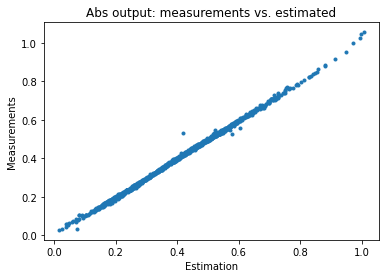

In [14]:
# plot the measured absolute value of the output over the estimated abs
import matplotlib.pyplot as plt
plt.plot(np.abs(X_abs_hat),np.abs(X_abs_Test),'.')
plt.ylabel('Measurements')
plt.xlabel('Estimation')
plt.title('Abs output: measurements vs. estimated')
plt.show()

ACLR is : 0.008793950496947442


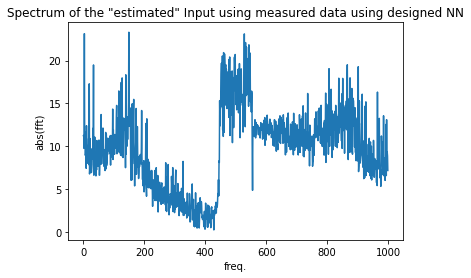

In [23]:
# plot the spectrum of the estimated NN output
X_hat_complex = X_real_hat + 1j * X_imag_hat
X_hat_complex = np.array(X_hat_complex)
fft_x_hat = np.fft.fftshift(np.fft.fft(X_hat_complex))
fft_x_hat_log10 = 10*np.log10(fft_x_hat)
plt.plot(np.abs(fft_x_hat_log10))
plt.ylabel('abs(fft)')
plt.xlabel('freq.')
plt.title('Spectrum of the "estimated" Input using measured data using designed NN')

# find the ACPR of the NN
fft_abs_channel = np.sum(np.square(np.abs(fft_x_hat[450:550])))
a = fft_x_hat[1:449]
a = np.append(a,fft_x_hat[551:])
fft_abs_adj     = np.sum(np.square(np.abs(a)))
ACLR = fft_abs_adj/fft_abs_channel
print('ACLR is :',ACLR)

ACLR is : 0.008489192980442196


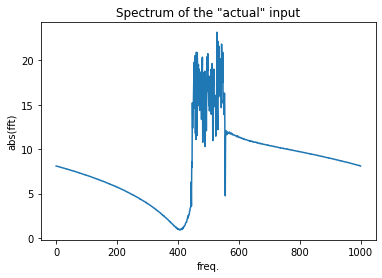

In [22]:
# plot the spectrum of the PA
X_complex_meas = X_real + 1j * X_imag
X_complex_meas = np.array(X_complex_meas)
fft_x_meas = np.fft.fftshift(np.fft.fft(X_complex_meas))
fft_x_meas_log10 = 10*np.log10(fft_x_meas)
plt.plot(np.abs(fft_x_meas_log10))
plt.ylabel('abs(fft)')
plt.xlabel('freq.')
plt.title('Spectrum of the "actual" input')

# find the ACPR of the PA
fft_abs_channel = np.sum(np.square(np.abs(fft_x_meas[450:550])))
a = fft_x_meas[1:449]
a = np.append(a,fft_x_meas[551:])
fft_abs_adj     = np.sum(np.square(np.abs(a)))
ACLR = fft_abs_adj/fft_abs_channel
print('ACLR is :',ACLR)